In [30]:
import pandas as pd
import os
import glob
import io 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from brainspace.gradient import GradientMaps
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
def get_gradients(matrix,side,region):

    if region!='ctx':
        matrix= cosine_similarity(matrix.T, matrix.T)

    gm = GradientMaps(n_components=4, random_state=0)
    gm.fit(matrix)

    grad_1 = gm.gradients_.T[0]
    grad_2 = gm.gradients_.T[1]
    grad_3 = gm.gradients_.T[2]
    grad_4 = gm.gradients_.T[3]

    gradient_df = pd.DataFrame({side+'_grad_1': grad_1, side+'_grad_2': grad_2, side+'_grad_3': grad_3, side+'_grad_4': grad_4})

    return gradient_df

In [32]:

import itertools
def reject_outliers_2(matrix, m=2.):

    mean_matrix = np.zeros((np.shape(matrix)[0],np.shape(matrix)[1]))
    for i, j in itertools.product(range(np.shape(matrix)[0]),range(np.shape(matrix)[1])):

        data = matrix[i,j,:]
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d / (mdev if mdev else 1.)
        mean_matrix[i,j] = np.mean(data[s < m])
    return mean_matrix

#data_points = np.array([[[10, 10, 10, 17, 10, 10], [12, 12, 12, 19, 12, 12], [11, 11, 11, 20, 11, 11]], [[10, 10, 10, 17, 10, 10], [12, 12, 12, 19, 12, 12], [11, 11, 11, 20, 11, 11]],[[10, 10, 10, 17, 10, 10], [12, 12, 12, 19, 12, 12], [11, 11, 11, 20, 11, 11]]])
#print(np.shape(data_points))
#val = reject_outliers_2(data_points, m=2.)
#print(val)




In [33]:
df = pd.read_table('../participants.tsv')
subjects = df.participant_id.to_list() 
subj = [ s.strip('sub-') for s in subjects ]


def get_mean_matrix(session,side,region):
    #subj = ['3119','3120']
    matrix_dir = '/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/cortex/gradients/'+session

    matrix = np.load(matrix_dir+"/sub-"+subj[0]+"_"+side+"_"+region+".npy")

    cube_matrix = np.zeros((np.shape(matrix)[0],np.shape(matrix)[1],len(subj)))

    


    for i,subjects in enumerate(subj):
        
        matrix = np.load(matrix_dir+"/sub-"+subjects+"_"+side+"_"+region+".npy")
        cube_matrix[:,:,i]=matrix

    mean_data = np.mean(cube_matrix, axis=2)
    #mean_data = reject_outliers_2(cube_matrix, m=2.)

    return mean_data

mean_ctx_L_12 = get_mean_matrix('month12','R','ctx')
mean_ctx_L_24 = get_mean_matrix('month24','R','ctx')

df_ctx_L_12 = get_gradients(mean_ctx_L_12,'R','ctx')
df_ctx_L_24 = get_gradients(mean_ctx_L_24,'R','ctx')




In [34]:

df_ctx_L_12['month'] = 'm12'
df_ctx_L_24['month'] = 'm24'


df_ctx_all = df_ctx_L_24.append(df_ctx_L_12)

print(df_ctx_all)

      R_grad_1  R_grad_2   R_grad_3   R_grad_4 month
0    10.671959 -0.346028  15.846913  -3.738582   m24
1    10.513997 -0.340520  16.764395 -12.904149   m24
2    10.428545 -0.337379  14.030590  -5.623032   m24
3    10.573250 -0.341866  16.361186 -11.583273   m24
4    10.449585 -0.343003  16.616849 -12.281807   m24
..         ...       ...        ...        ...   ...
495  -0.224566  2.275097  -0.315686  -0.894509   m12
496  -0.226355  2.269282  -1.460131   0.146010   m12
497  -0.215996  2.269082  -0.685510  -0.042028   m12
498  -0.222379  2.235013  -1.148659  -0.490342   m12
499  -0.224442  2.242982  -1.016235  -0.371137   m12

[1000 rows x 5 columns]


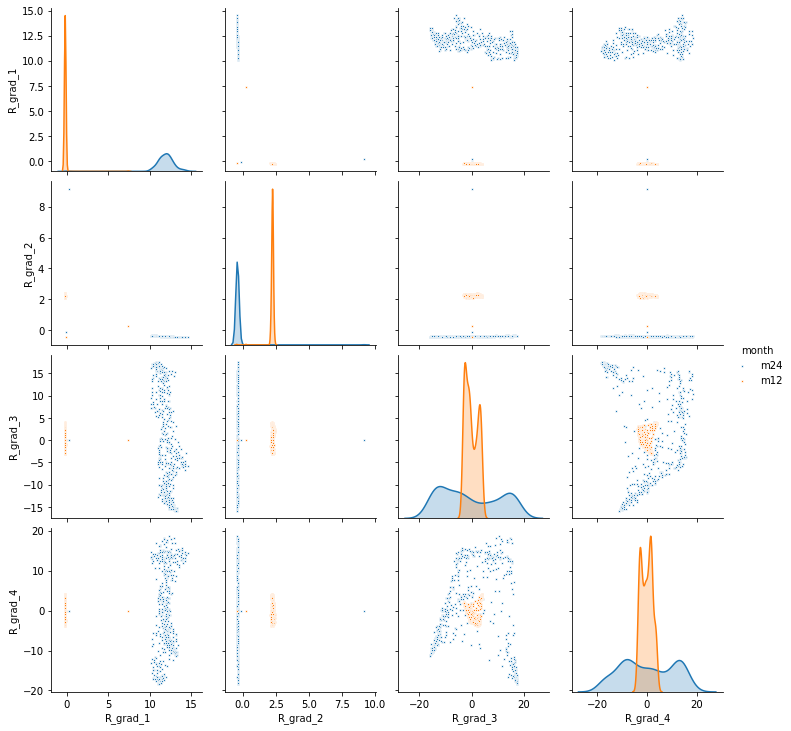

In [35]:
out_path='/home/dimuthu1/scratch/PPMI_project2/derivatives/analysis/cortex/group_analysis'
sns_plot_L = sns.pairplot(df_ctx_all,plot_kws={"s": 5}, hue="month")
sns_plot_L.savefig(out_path+"/group_stat_L.png")
